In [37]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

import particle.literals
from particle import width_to_lifetime, lifetime_to_width # MeV <-> ns
import pandas as pd

In [38]:
speed_light = 29.98 #cm/ns
hbar = lifetime_to_width(1)/1000 # GeV ns

me = particle.literals.e_minus.mass/1000
mmu = particle.literals.mu_minus.mass/1000
mtau = particle.literals.tau_minus.mass/1000
mUpsilon = particle.literals.Upsilon_1S.mass/1000
widthUpsilon = particle.literals.Upsilon_1S.width/1000
mUpsilon2S = particle.literals.Upsilon_2S.mass/1000
widthUpsilon2S = particle.literals.Upsilon_2S.width/1000
mUpsilon3S = particle.literals.Upsilon_3S.mass/1000
widthUpsilon3S = particle.literals.Upsilon_3S.width/1000
mUpsilon4S = particle.literals.Upsilon_4S.mass/1000
widthUpsilon4S = particle.literals.Upsilon_4S.width/1000
mJpsi = particle.literals.Jpsi_1S.mass/1000
widthJpsi = particle.literals.Jpsi_1S.width/1000
alpha_em = 1/137
fUpsilon = 0.659
fUpsilon2S = 0.481
fUpsilon3S = 0.405
fJpsi = 0.4104 # 2005.01845

fa = mtau

In [39]:
corr_Jpsi = 0.92
corr_2S = 0.21
corr_3S = 0.16
corr_4S = 3e-5

In [40]:
def Cgammagamma(ma, mlep, s, cgg0=0):
    def f(x):
        if x >= 1:
            return np.arcsin(x**-0.5)
        else:
            return np.pi/2+0.5j*np.log((1+(1-x)**0.5)/(1-(1-x)**0.5))
    B3 = lambda x, y: 1+x*y/(x-y)*(f(x)**2-f(y)**2)
    c = cgg0
    for m in mlep:
        c += B3(4*m**2/ma**2, 4*m**2/s)/mlep
    return -c*alpha_em/np.pi

In [41]:
def Gamma_phi(mphi: float, cgg0=0) -> list[float]:
    def f(x):
        if x >= 1:
            return np.arcsin(x**-0.5)
        else:
            return np.pi/2+0.5j*np.log((1+(1-x)**0.5)/(1-(1-x)**0.5))
    B1 = lambda x: 1-x*f(x)**2
    res = [alpha_em**2*mphi**3/(fa**2*(4*np.pi)**3)*abs(cgg0+B1(4*mtau**2/mphi**2)+B1(4*me**2/mphi**2)+B1(4*mmu**2/mphi**2))**2, 0, 0, 0]
    #res = [4*np.pi*a_em**2/Lambda**2*mphi**3*abs(B1(4*mtau**2/mphi**2)+0*B1(4*mmu**2/mphi**2)+0*B1(4*me**2/mphi**2))**2/(16*np.pi)**2, 0, 0, 0]
    if mphi > 2*me:
        res[1] = mphi * me**2/(8*np.pi*fa**2)*np.sqrt(1-4*me**2/mphi**2)
    if mphi > 2*mmu:
        res[2] = mphi * mmu**2/(8*np.pi*fa**2)*np.sqrt(1-4*mmu**2/mphi**2)
    if mphi > 2*mtau:
        res[3] = mphi * mtau**2/(8*np.pi*fa**2)*np.sqrt(1-4*mtau**2/mphi**2)
    return res

def BR_gg(ma, cgg0=0):
    gamma = Gamma_phi(ma, cgg0)
    return gamma[0]/sum(gamma)

def BR_ee(ma, cgg0=0):
    gamma = Gamma_phi(ma, cgg)
    return gamma[1]/sum(gamma)

def BR_mumu(ma, cgg0=0):
    gamma = Gamma_phi(ma, cgg0)
    return gamma[2]/sum(gamma)

def BR_tautau(ma, cgg0=0):
    gamma = Gamma_phi(ma, cgg0)
    return gamma[3]/sum(gamma)

In [42]:
def BR_Upsilon_gammaPS(ma, s, cgg0=0):
    return alpha_em/(216*widthUpsilon)*mUpsilon*fUpsilon**2*abs(Cgammagamma(ma, [mtau], s, cgg0))**2*(1-ma**2/mUpsilon**2)**3

In [43]:
def BR_Jpsi_gammaPS(ma, cgg0=0):
    return 4*alpha_em/(216*widthUpsilon)*mUpsilon*fUpsilon**2*abs(Cgammagamma(ma, [mtau], mJpsi**2, cgg0))**2*(1-ma**2/mUpsilon**2)**3

In [44]:
ma_list = [10**x for x in np.linspace(-3, np.log10(mUpsilon3S), 200)]
BR_list = [BR_Upsilon_gammaPS(m, mUpsilon**2) for m in ma_list]

In [45]:
Belle_tautau = pd.read_csv('Belle_Upsilon_tautau.csv')
BaBar_tautau = pd.read_csv('BaBar_Upsilon3S.csv').sort_values(by='x')
BaBar_tautau = BaBar_tautau.loc[BaBar_tautau[' y'] > 0]
BaBar_3S_gammainv = pd.read_csv('BaBar_3S_gammainv.csv')
BaBar_1S_gammainv = pd.read_csv('BaBar_1S_gammainv.csv')
BESIII_3gamma = pd.read_csv('BESIII_Jpsi_3gamma.csv')
BESIII_gammainv = pd.read_csv('BESIII_gammainv.csv')

In [46]:
limits_Belle_tau = [float((Belle_tautau[' y'][i]/(BR_Upsilon_gammaPS(Belle_tautau['x'][i], mUpsilon**2)))**0.5) for i in range(len(Belle_tautau['x']))]

limits_BESIII_Jpsi = [float((BESIII_3gamma['gagamma_GeV-1'][i]/Cgammagamma(BESIII_3gamma['ma_GeV'][i], [mtau], mJpsi**2))**0.5) for i in BESIII_3gamma.index]

limits_BaBar_tautau = [float((BaBar_tautau[' y'][i]/(BR_tautau(BaBar_tautau['x'][i])*BR_Upsilon_gammaPS(BaBar_tautau['x'][i], mUpsilon3S**2)*(1+1/corr_3S)))**0.5) for i in BaBar_tautau.index]

limits_BESIII_gammainv = [float((BESIII_gammainv['BR'][i]/(BR_Jpsi_gammaPS(BESIII_gammainv['ma_GeV'][i])*(1+1/corr_Jpsi)))**0.5) for i in BESIII_gammainv.index]

limits_BaBar_3S_gammainv = [float((BaBar_3S_gammainv['BR'][i]/(BR_Upsilon_gammaPS(BaBar_3S_gammainv['ma_GeV'][i], mUpsilon3S**2)*(1+1/corr_3S)))**0.5) for i in BaBar_3S_gammainv.index]
limits_BaBar_1S_gammainv = [float((BaBar_1S_gammainv['BR'][i]/(BR_Upsilon_gammaPS(BaBar_1S_gammainv['ma_GeV'][i], mUpsilon**2)))**0.5) for i in BaBar_1S_gammainv.index]

/tmp/ipykernel_4073/1277902717.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  limits_Belle_tau = [float((Belle_tautau[' y'][i]/(BR_Upsilon_gammaPS(Belle_tautau['x'][i], mUpsilon**2)))**0.5) for i in range(len(Belle_tautau['x']))]
/tmp/ipykernel_4073/1277902717.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  limits_BESIII_Jpsi = [float((BESIII_3gamma['gagamma_GeV-1'][i]/Cgammagamma(BESIII_3gamma['ma_GeV'][i], [mtau], mJpsi**2))**0.5) for i in BESIII_3gamma.index]
/tmp/ipykernel_4073/1277902717.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a si

In [47]:
def f(x):
    if x >= 1:
        return np.arcsin(x**-0.5)
    else:
        return np.pi/2+0.5j*np.log((1+(1-x)**0.5)/(1-(1-x)**0.5))
B1 = lambda x: -x*f(x)**2

def Gamma_photons(ma):
    return alpha_em**2*ma**3/(fa**2*(4*np.pi)**3)*abs(B1(4*mtau**2/ma**2))**2

def coupling_length_PS(length, ma, boosted=True):
    s=mJpsi**2
    if boosted:
        boost = (s+ma**2)/(2*np.sqrt(s)*ma)
    else:
        boost = 1
    return np.sqrt((4*np.pi)**3*mtau**2*hbar*speed_light/(alpha_em**2*np.abs(B1(4*mtau**2/ma**2))**2* ma**3*length)*boost)/(mtau*1e-3)

def coupling_length_PS_BelleII(length, ma, boosted=True):
    s=10.58**2
    if boosted:
        boost = (s+ma**2)/(2*np.sqrt(s)*ma)
    else:
        boost = 1
    return np.sqrt((4*np.pi)**3*mtau**2*hbar*speed_light/(alpha_em**2*np.abs(B1(4*mtau**2/ma**2))**2* ma**3*length)*boost)/(mtau*1e-3)

In [48]:
for i, ma in enumerate(BESIII_3gamma['ma_GeV']):
    limits_BESIII_Jpsi[i] = max(limits_BESIII_Jpsi[i], coupling_length_PS(700, ma, True))

In [49]:
for i, ma in enumerate(BESIII_gammainv['ma_GeV']):
    if limits_BESIII_gammainv[i] > coupling_length_PS(700, ma, True):
        limits_BESIII_gammainv = limits_BESIII_gammainv[:i]
        break

(0.001, 10)

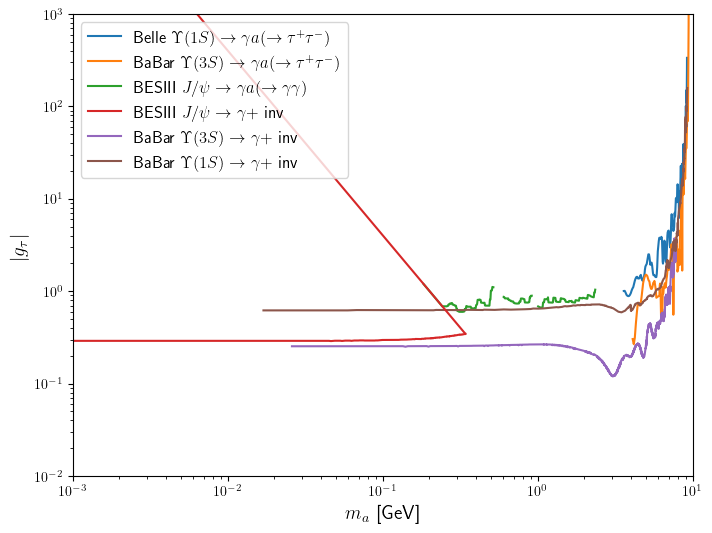

In [50]:
plt.figure(figsize=(8, 6))
plt.loglog(Belle_tautau['x'], limits_Belle_tau, label=r'Belle $\Upsilon(1S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BaBar_tautau['x'], limits_BaBar_tautau, label=r'BaBar $\Upsilon(3S)\to \gamma a(\to \tau^+\tau^-)$')
plt.loglog(BESIII_3gamma['ma_GeV'], limits_BESIII_Jpsi, label=r'BESIII $J/\psi\to\gamma a(\to \gamma\gamma)$')
plt.loglog(BESIII_gammainv['ma_GeV'][:len(limits_BESIII_gammainv)], limits_BESIII_gammainv, label=r'BESIII $J/\psi\to\gamma +$ inv')
plt.loglog(BaBar_3S_gammainv['ma_GeV'], limits_BaBar_3S_gammainv, label=r'BaBar $\Upsilon(3S)\to\gamma +$ inv')
plt.loglog(BaBar_1S_gammainv['ma_GeV'], limits_BaBar_1S_gammainv, label=r'BaBar $\Upsilon(1S)\to\gamma +$ inv')
plt.loglog(BESIII_gammainv['ma_GeV'][:len(limits_BESIII_gammainv)], [coupling_length_PS(700, ma, True) for ma in BESIII_gammainv['ma_GeV'][:len(limits_BESIII_gammainv)]], c='tab:red')
plt.xlim(1e-1, 20)
#plt.ylim(1e1, 1e5)
plt.xlabel(r'$m_a$ [GeV]', fontsize=14)
plt.ylabel(r'$|g_{\tau}|$', fontsize=14)
plt.legend(fontsize=12)
plt.ylim(1e-2, 1e3)
plt.xlim(1e-3, 10)
#plt.savefig('quarkonia.png')

In [51]:
pd.DataFrame({'ma_GeV': Belle_tautau['x'], 'gtau': limits_Belle_tau}).to_csv('../data/quarkonia/Belle_Y1Stautau.csv', index=False)
pd.DataFrame({'ma_GeV': BaBar_tautau['x'], 'gtau': limits_BaBar_tautau}).to_csv('../data/quarkonia/BaBar_Y3Stautau.csv', index=False)
pd.DataFrame({'ma_GeV': BESIII_3gamma['ma_GeV'], 'gtau': limits_BESIII_Jpsi}).to_csv('../data/quarkonia/BESIII_3gamma.csv', index=False)
pd.DataFrame({'ma_GeV': BESIII_gammainv['ma_GeV'][:len(limits_BESIII_gammainv)], 'gtau':limits_BESIII_gammainv, 'gtau_7m': [coupling_length_PS(700, ma, True) for ma in BESIII_gammainv['ma_GeV'][:len(limits_BESIII_gammainv)]]}).to_csv('../data/quarkonia/BESIII_gammainv.csv', index=False)